#**DCGAN - Unsupervised Representation Learning With Deep Convolution Generative Adversarial Networks**

In this project, I have implemented the DCGAN Model. It is the most basic version of GAN with simple architecture(Few Convolution layers for discriminator and Upsampling or ConvTranspose layers for Generator)

**Original GAN Paper** : [GAN](https://arxiv.org/pdf/1406.2661.pdf)

**Deep Convolution GAN Paper** : [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)

**Dataset Download** : [Celeb Faces](https://www.kaggle.com/jessicali9530/celeba-dataset)

**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

## **Imports**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torchvision.utils import make_grid

import os
from torchvision.utils import save_image
import glob
import math 
import gc
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

## **Downloading and Loading the data**

In [3]:
batch_size = 128
latent_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
!pip install kaggle
%env KAGGLE_USERNAME= roysoham
# %env KAGGLE_KEY=

# %cd /content/drive/Mydrive      Uncomment this if you want to save it to your drive
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip"      # Change the folder name accordingly if you save the images in your drive

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [21]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Dataload(Dataset):
    def __init__(self, transform = True):
        self.transforms = transform
        self.train_image = []
        self.train_image = sorted(glob.glob(os.path.join('/content/img_align_celeba/img_align_celeba', '*.jpg')))
        if transform:
            self._init_transform()

    def _init_transform(self):
        self.transform = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        

    def __getitem__(self, index):
        img = pil_loader(self.train_image[index])
        if self.transforms:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.train_image)

train_dataset = Dataload()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2, drop_last=True)

## **Generative Adversarial Networks - DCGAN**

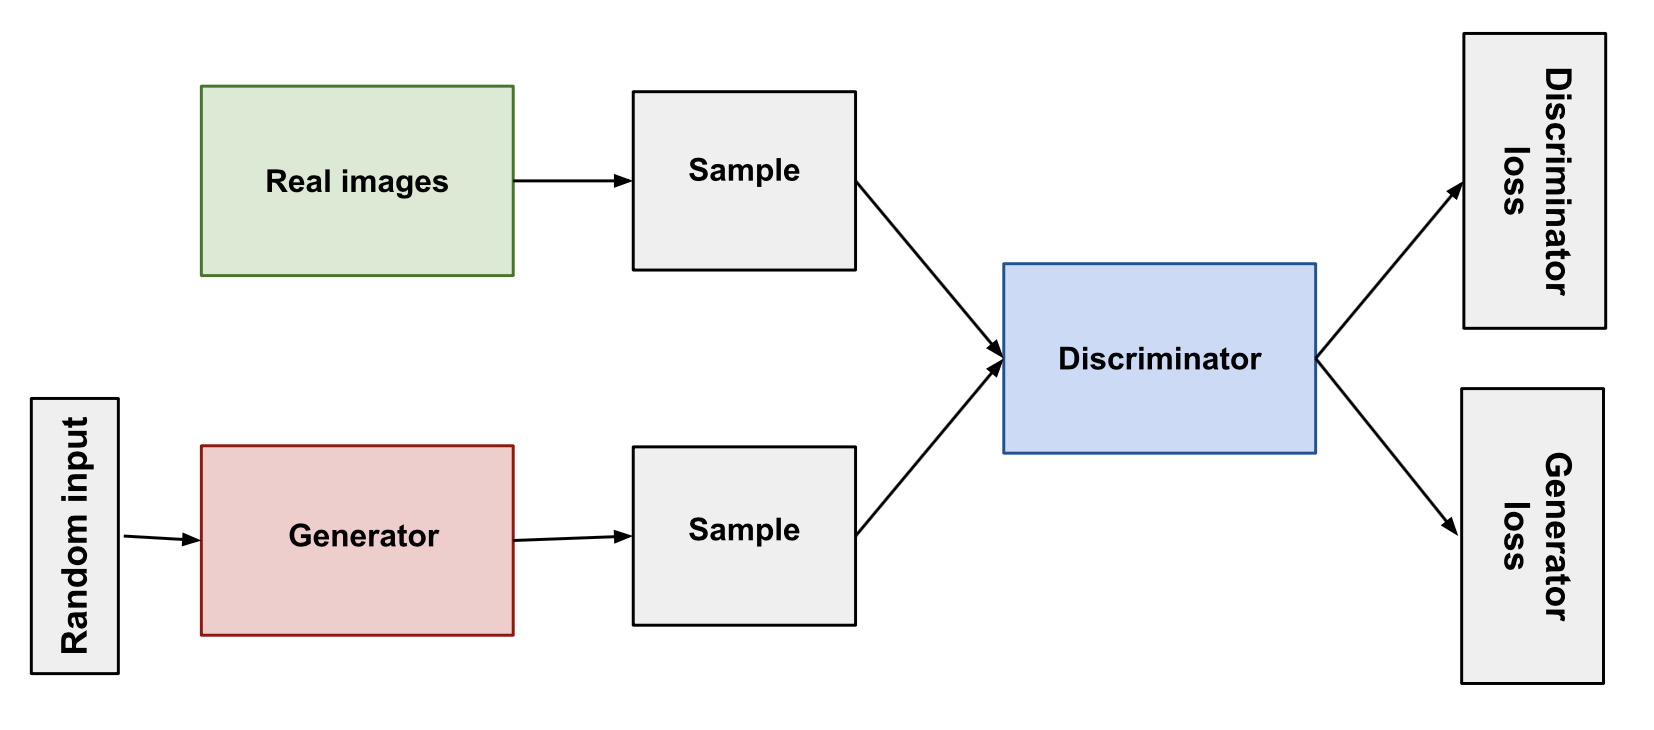

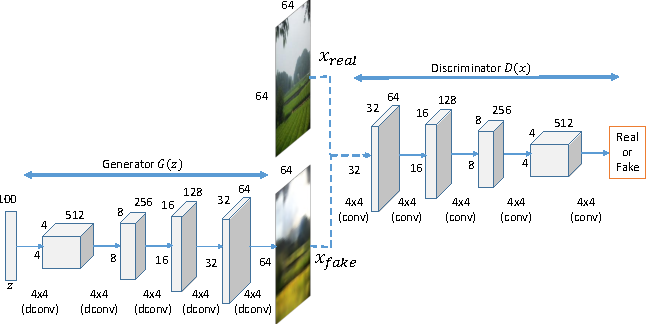

In [42]:
# Initialising the weights for the generator and discriminator for stable training 

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [43]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.lin = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100, 32 * 8 * 2 * 2)
        )

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.to(device)
        x = self.lin(x)
        x = x.view(x.shape[0], 32 * 8, 2, 2)
        x = self.gen(x)
        return x


generator = Generator()

generator.to(device)

generator.apply(weights_init)

def get_model_summary(model, input_tensor_shape):
    summary(generator.to(device), input_tensor_shape)
get_model_summary(generator, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 100]               0
            Linear-2                 [-1, 1024]         103,424
   ConvTranspose2d-3            [-1, 128, 4, 4]         524,288
       BatchNorm2d-4            [-1, 128, 4, 4]             256
         LeakyReLU-5            [-1, 128, 4, 4]               0
   ConvTranspose2d-6             [-1, 64, 8, 8]         131,072
       BatchNorm2d-7             [-1, 64, 8, 8]             128
         LeakyReLU-8             [-1, 64, 8, 8]               0
   ConvTranspose2d-9           [-1, 32, 16, 16]          32,768
      BatchNorm2d-10           [-1, 32, 16, 16]              64
        LeakyReLU-11           [-1, 32, 16, 16]               0
  ConvTranspose2d-12            [-1, 3, 32, 32]           1,536
             Tanh-13            [-1, 3, 32, 32]               0
Total params: 793,536
Trainable params:

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Flatten(),

            nn.Linear(32 * 8 * 2 * 2, 1)
        )

    def forward(self, x):
        x = x.to(device)
        return self.dis(x)

discriminator = Discriminator()

discriminator.to(device)

discriminator.apply(weights_init)

def get_model_summary(model, input_tensor_shape):
    summary(discriminator.to(device), input_tensor_shape)
get_model_summary(discriminator, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,536
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,768
         LeakyReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]         131,072
         LeakyReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 2, 2]         524,288
         LeakyReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                    [-1, 1]           1,025
Total params: 690,689
Trainable params: 690,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 2.63
Estimated T

## **Training**

In [45]:
epoch_Dlosses = []             
epoch_Glosses = []
epoch_Real_Score = []
epoch_Fake_Score = []
epoch_Generator_Score = []

In [46]:
epochs = 10
#------------YOUR CODE HERE----------------#
# Define the learning rate and optimizer 
# GANs are very sensitive to hyperparameters so set your learning rate accordingly

lr = 2e-4
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCEWithLogitsLoss()
#------------------------------------------#

# Loading the checkpoints if you need to continue from where you left

''' Uncomment the below part to load the checkpoints if you have saved already'''
# checkpoint = torch.load('/content/generator_GANS_Celeb.pt')
# generator.load_state_dict(checkpoint['model_state_dict'])
# generator.to(device)
# optimizerG.load_state_dict(checkpoint['optimizer_state_dict'])

# checkpoint = torch.load('/content/discriminator_GANS_Celeb.pt')
# discriminator.load_state_dict(checkpoint['model_state_dict'])
# discriminator.to(device)
# optimizerD.load_state_dict(checkpoint['optimizer_state_dict'])


# Defining the Train function for Generator and Discriminator

def train_discriminator(real_images, optimizer):
    optimizer.zero_grad()

    real_images = real_images.to(device)
    real_pred = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1)
    real_pred = real_pred.to(device)
    real_targets = real_targets.to(device)
    real_loss = criterion(real_pred, real_targets)
    real_score = torch.mean(torch.sigmoid(real_pred)).item()
    z = torch.randn(batch_size, latent_size, 1, 1)
    z = z.to(device)
    fake_images = generator(z)
    fake_pred = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1)
    fake_pred = fake_pred.to(device)
    fake_targets = fake_targets.to(device)
    fake_loss = criterion(fake_pred, fake_targets)
    fake_score = torch.mean(torch.sigmoid(fake_pred)).item()

    discriminator_loss = fake_loss + real_loss
    discriminator_loss.backward()
    optimizer.step()

    return discriminator_loss.item(), real_score, fake_score


def train_generator(optimizer):

    optimizer.zero_grad()

    z = np.random.uniform(-1, 1, size=(batch_size, latent_size, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    generator_images = generator(z)
    generator_pred = discriminator(generator_images)
    generator_targets = torch.ones(batch_size, 1)
    generator_pred = generator_pred.to(device)
    generator_targets = generator_targets.to(device)
    generator_loss = criterion(generator_pred, generator_targets)
    generator_score = torch.mean(torch.sigmoid(generator_pred)).item()

    generator_loss.backward()
    optimizer.step()

    return generator_loss.item(), generator_score


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# To save the images so as to keep a progress of the learning of Generator

sample_dir = "/content/GANimages/CelebA"
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

def save_samples(index1, index2, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{}-{}.png'.format(index1, index2)
    save_image((fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# TRAINING

for epoch in range(epochs):
    
    start_time = time.monotonic()
    
    print(f"Epoch: {epoch + 1}")
    train_DLoss_batch = []
    train_GLoss_batch = []
    train_real_score = []
    train_fake_score = []
    train_generator_score = []

    count = 0

    for idx,(real_images) in enumerate(train_dataloader):
        real_images = 2*real_images - 1
        discriminator_loss, real_score, fake_score = train_discriminator(real_images, optimizerD)
        generator_loss, generator_score = train_generator(optimizerG)
        train_DLoss_batch.append(discriminator_loss)
        train_GLoss_batch.append(generator_loss)
        train_real_score.append(real_score)
        train_fake_score.append(fake_score)
        train_generator_score.append(generator_score)
        if (idx+1)%100 == 0:
            print(f"Epoch [{(idx+1)//100}/15] Discriminator Batch Loss: {discriminator_loss:.5f}   Generator Batch Loss: {generator_loss:.5f}   Real Score: {real_score:.5f}   Fake Score: {fake_score}   Generator Score: {generator_score:.5f}")
            save_samples(epoch+1, int((idx+1)//100), fixed_latent, show=False)

    epoch_Dlosses.append(sum(train_DLoss_batch)/len(train_dataloader))
    epoch_Glosses.append(sum(train_GLoss_batch)/len(train_dataloader))
    epoch_Real_Score.append(sum(train_real_score)/len(train_dataloader))
    epoch_Fake_Score.append(sum(train_fake_score)/len(train_dataloader))
    epoch_Generator_Score.append(sum(train_generator_score)/len(train_dataloader))

    # Saving the Generator and Discriminator weights 
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimizerD.state_dict(),
        'loss': epoch_Dlosses[-1],
        }, '/content/discriminator_GANS_Celeb.pt')

    torch.save({
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimizerG.state_dict(),
        'loss': epoch_Glosses[-1],
        }, '/content/generator_GANS_Celeb.pt')

    print(f"Epoch {epoch + 1} Training Over")
    print(f"Discriminator Epoch Loss: {epoch_Dlosses[-1]:.5f}   Generator Epoch Loss: {epoch_Glosses[-1]:.5f}   Real Score: {epoch_Real_Score[-1]:.5f}   Fake Score: {epoch_Fake_Score[-1]:.5f}   Generator Score: {epoch_Generator_Score[-1]:.5f}")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))
    

print("OVERALL TRAINING COMPLETE")

Epoch: 1
Epoch [1/15] Discriminator Batch Loss: 0.77796   Generator Batch Loss: 0.64705   Real Score: 0.97307   Fake Score: 0.5278208255767822   Generator Score: 0.52359
Epoch [2/15] Discriminator Batch Loss: 0.81625   Generator Batch Loss: 0.63917   Real Score: 0.94723   Fake Score: 0.5325852632522583   Generator Score: 0.52773
Epoch [3/15] Discriminator Batch Loss: 0.84880   Generator Batch Loss: 0.63149   Real Score: 0.93709   Fake Score: 0.5416936874389648   Generator Score: 0.53184
Epoch [4/15] Discriminator Batch Loss: 0.93441   Generator Batch Loss: 0.59000   Real Score: 0.91215   Fake Score: 0.5683654546737671   Generator Score: 0.55455
Epoch [5/15] Discriminator Batch Loss: 0.94415   Generator Batch Loss: 0.56058   Real Score: 0.80991   Fake Score: 0.5162328481674194   Generator Score: 0.57104
Epoch [6/15] Discriminator Batch Loss: 0.96572   Generator Batch Loss: 0.62849   Real Score: 0.86674   Fake Score: 0.5578967332839966   Generator Score: 0.53384
Epoch [7/15] Discriminato

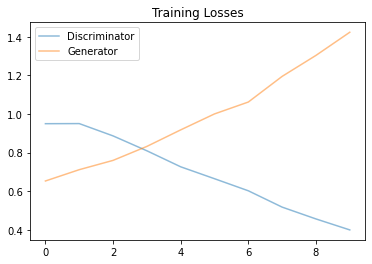

In [48]:
plt.plot(epoch_Dlosses, label='Discriminator', alpha=0.5)
plt.plot(epoch_Glosses, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

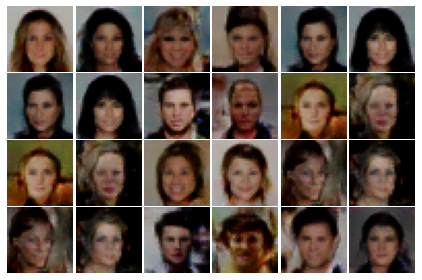

In [70]:
rows, cols = 4, 6
fig, axs = plt.subplots(rows, cols)

z = np.random.uniform(-1, 1, size=(rows*cols, latent_size))
z = torch.from_numpy(z).float()
fake_images = generator(z)

for i in range(rows):
    for j in range(cols):
        fake_image = fake_images[i*rows + j].permute(1, 2, 0).cpu().detach().numpy()
        fake_image = ((fake_image + 1)*255 / 2).astype(np.uint8)
        axs[i][j].imshow( fake_image.reshape((32,32,3)) )
        axs[i][j].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.02)
plt.show()

### **Results**

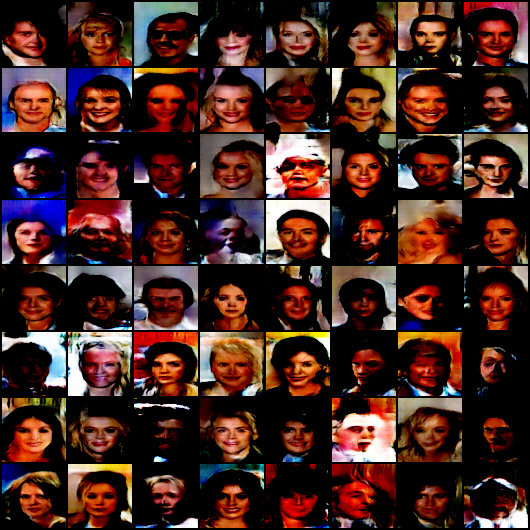

You can check out a GIF animation on how the Generator learns to generate human faces : [GitHub Repo](https://github.com/Vinayak-VG/My-Projects/tree/main/Computer_Vision_Projects/Generative_Adversarial_Networks-GAN/DCGAN)

## **End Note**


Here you go! We have successfully implemented Generative Adversarial Networks. This is a very simple version of GAN( DCGAN ). There has been a lot of advancement in the field of GANs and you can definitely check out the complex models and how they are able to generate high resolution images.

Here's a list of things which you can try it out and experiment

1. StarGAN

2. StackGAN

3. StyleGAN

Problems with GANs: There are a lots of problems while training a GAN. These are a few which come while training a GAN. I would suggest you look up these problems and try to reason out why that may happen and you could refer the internet for solution to the problem :)

1. Mode Collapse: It is the state when the Generator outputs only a same kind of images. Basically it overfits to a very small distribution in the real dataset.

2. Vanishing Gradients
